# Pharmacy Density in Toronto: Increasing Access to Medicine
## Introduction / Business Problem
In the city of Toronto, with an approximate population of 6,341,935, there is a need for advanced and expanding health infrastructure. Within healthcare, pharmacy and prescription drugs are at the forefront of discussion with rising costs. With barriers already in the form of costs, it is important for the health of a population to be able to access these drugs conveniently and adhere to the guidelines given.

I will seek to find the neighborhoods in Toronto where there is a lack of pharmacies and hopefully identify the single neighborhood with the greatest need. This information could be key for any investors that are looking to open an independent pharmacy, or for recent pharmacy graduates that are also looking to open and run their own independent pharmacy. By contextualizing the neighborhoods in terms of the density of pharmacies and neighborhood population, they will be able to make decisions to best serve the greater Toronto area and its citizens.

## Data
I will use Foursquare location data and web scraped postal codes from Wikipedia to be able to analyze neighborhoods and their pharmacy density. This data will be drawn through Foursquare's API by defining the search parameters for each neighborhood as nearby pharmacies and then joining this to our postal codes for the Toronto area.

I will also be using population data from the 2016 census that is available through the Statistics Canada government website in CSV format (https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Table.cfm?Lang=Eng&T=1201&S=22&O=A). This data contains raw population numbers for each postal code and will also be joined to our data frame so that we are able to contextualize the need for pharmacies as it is compared to the total population of the postal code.

## Goals in this Notebook

- Build a dataframe of neighborhoods in Toronto by web scraping the data from the Wikipedia page.
- Get the geographical coordinates of the neighborhoods and plot these neighborhoods.
- Obtain the venue data for the pharmacies of these areas from the Foursquare API.
- Explore and cluster the neighborhoods.
- Select the best cluster to open a new pharmacy.


In [1]:
# Installing all packages needed.

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0
import folium # map rendering library

# Plotly for visualizations
import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# Packages for web-scraping
import urllib.request
from bs4 import BeautifulSoup


print('Libraries imported.')

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ 

Libraries imported.


# Web-Scraping our Data

First, we will need to webscrape a Wikipedia page containing all of Canada's postal codes to be able to segment and plot our Toronto neighborhoods. For this we will use BeautifulSoup and URLLib.

In [2]:
# Defining our target URL
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

# Setting it up to open with BeautifulSoup
page = urllib.request.urlopen(url)
soup = BeautifulSoup(page, "lxml")

# Identifying the table and rows we will be scraping from
table = soup.find('table',{'class':'wikitable'})
table_rows = table.find_all('tr')

Now we will write a loop to find all of our FSAs. The way we find it will group them all together in one column, so the rest of the lines will be to break them apart into separate columns and format to the specifications in the assignment.

In [3]:
data = []
for row in table_rows:
    data.append([t.text.strip() for t in row.find_all('td')])

df = pd.DataFrame(data, columns=['PostalCode','Borough','Neighborhood'])
df = df[df.Borough.str.contains("Not assigned") == False] # Removing any Postal Codes that are not assigned
df.Neighborhood.fillna(df.Borough, inplace=True) # Filling blank neighborhood values with the corresponding Borough
df

,PostalCode,Borough,Neighborhood
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,Regent Park / Harbourfront
6,M6A,North York,Lawrence Manor / Lawrence Heights
7,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government
9,M9A,Etobicoke,Islington Avenue
10,M1B,Scarborough,Malvern / Rouge
12,M3B,North York,Don Mills
13,M4B,East York,Parkview Hill / Woodbine Gardens
14,M5B,Downtown Toronto,"Garden District, Ryerson"


# Joining Lat & Lon Values

Now that we have our MSA data, we will need to bring in our geospatial coordinates.
First, we'll read the geospatial CSV.

In [4]:
gsp = pd.read_csv('../input/geospatial-coordinates/Geospatial_Coordinates.csv')
pop = pd.read_csv('../input/toronto-2016-population/TorontoPop.csv') # we will also go ahead and load our population numbers

Now we can simply merge on our Postal Code values and that will leave us with the previous dataframe with the addition of lat & lon values. We will drop the redundant Postal Code column.

In [5]:
# Performing an inner merge with our coordinates
df2 = df.merge(gsp, how='inner', left_on='PostalCode', right_on='Postal Code')
df2 = df2.drop(['Postal Code'], axis=1) # Dropping redundant postal code value
# Joining to our population data
df2 = df2.merge(pop, how='inner', left_on='PostalCode', right_on='Geographic code')
df2 = df2.drop(['Geographic code'], axis=1) # Dropping redundant value
df2

,PostalCode,Borough,Neighborhood,Latitude,Longitude,"Population, 2016"
0,M3A,North York,Parkwoods,43.753259,-79.329656,34615.0
1,M4A,North York,Victoria Village,43.725882,-79.315572,14443.0
2,M5A,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636,41078.0
3,M6A,North York,Lawrence Manor / Lawrence Heights,43.718518,-79.464763,21048.0
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government,43.662301,-79.389494,10.0
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242,35594.0
6,M1B,Scarborough,Malvern / Rouge,43.806686,-79.194353,66108.0
7,M3B,North York,Don Mills,43.745906,-79.352188,13324.0
8,M4B,East York,Parkview Hill / Woodbine Gardens,43.706397,-79.309937,18628.0
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,12785.0


# Plotting our Neighborhoods with Folium

Now that we have our joined table, let's plot our neighborhoods. First we will need the central coordinates for Toronto. We can find this with the Nominatim from the geopy.geocode package.

In [6]:
# Defining our city
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)

# Naming our coordinates
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Toronto are 43.6534817, -79.3839347.


In [7]:
# Limiting our boroughs to only those containing the word Toronto so that we aren't plotting all of Canada's postal codes.
toronto_data = df2[df2.Borough.str.contains("Toronto") == True]
toronto_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,"Population, 2016"
2,M5A,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636,41078.0
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government,43.662301,-79.389494,10.0
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,12785.0
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,2951.0
19,M4E,East Toronto,The Beaches,43.676357,-79.293031,25044.0


In [8]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Borough'], toronto_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

# Foursquare API for Venue Data

Time to begin gaining our venue data.

In [9]:
# Defining our Foursquare credentials:
CLIENT_ID = 'QP3VVQK1XEFRVYOJRIZK22I3LYJZ23GWE5QNQW0I3M3XVI2M' # your Foursquare ID
CLIENT_SECRET = 'QCKLK1WG0Z3C1NT3FSWYFNVOHOCN2JQ01BZSIHWINBRM0T0X' # your Foursquare Secret
VERSION = '20200323' # Foursquare API version
LIMIT = '100'
RADIUS = '500'
QUERY = 'pharmacy'

Below we will now write a function to make an API call for pharmacies in each of our neighborhoods.

In [10]:
LIMIT = 500  # limit of number of venues returned by Foursquare API
search_query = 'Pharmacy'

def getNearbyVenues(names, latitudes, longitudes, radius=1000):

    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)

        # create the API request URL
        url = "https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}".format(
            CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, search_query, radius, LIMIT
        )

        # make the GET request
        try:
            results = requests.get(url).json()["response"]["groups"][0]["items"]
        except:
            print("can't get request results from url")

        # return only relevant information for each nearby venue
        venues_list.append(
            [
                (
                    name,
                    lat,
                    lng,
                    v["venue"]["name"],
                    v["venue"]["location"]["lat"],
                    v["venue"]["location"]["lng"],
                    v["venue"]["categories"][0]["name"],
                    v["venue"]["id"],
                )
                for v in results
            ]
        )

    nearby_venues = pd.DataFrame(
        [item for venue_list in venues_list for item in venue_list]
    )
    nearby_venues.columns = [
        "Neighborhood",
        "NeighborhoodLatitude",
        "NeighborhoodLongitude",
        "Venue",
        "VenueLatitude",
        "VenueLongitude",
        "VenueCategory",
        "VenueID"
    ]

    return nearby_venues

Now we can execute it by supplying our Neighborhood and geo data.

In [11]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

Regent Park / Harbourfront
Queen's Park / Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond / Adelaide / King
Dufferin / Dovercourt Village
Harbourfront East / Union Station / Toronto Islands
Little Portugal / Trinity
The Danforth West / Riverdale
Toronto Dominion Centre / Design Exchange
Brockton / Parkdale Village / Exhibition Place
India Bazaar / The Beaches West
Commerce Court / Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West
High Park / The Junction South
North Toronto West
The Annex / North Midtown / Yorkville
Parkdale / Roncesvalles
Davisville
University of Toronto / Harbord
Runnymede / Swansea
Moore Park / Summerhill East
Kensington Market / Chinatown / Grange Park
Summerhill West / Rathnelly / South Hill / Forest Hill SE / Deer Park
CN Tower / King and Spadina / Railway Lands / Harbourfront West / Bathurst
 Quay / South Niagara / Island airport
Rosed

In [12]:
print(toronto_venues.shape)
toronto_venues.head()

(466, 8)


,Neighborhood,NeighborhoodLatitude,NeighborhoodLongitude,Venue,VenueLatitude,VenueLongitude,VenueCategory,VenueID
0,Regent Park / Harbourfront,43.654260,-79.360636,Shoppers Drug Mart,43.655528,-79.364252,Pharmacy,4ae78eadf964a52060ac21e3
1,Regent Park / Harbourfront,43.654260,-79.360636,Shoppers Drug Mart,43.660204,-79.361332,Pharmacy,55fe0dd0498ed5a5423b6d17
2,Queen's Park / Ontario Provincial Government,43.662301,-79.389494,Shoppers Drug Mart,43.661799,-79.383240,Pharmacy,4b56336cf964a520070528e3
3,Queen's Park / Ontario Provincial Government,43.662301,-79.389494,Shoppers Drug Mart,43.658475,-79.384868,Pharmacy,4c054c04f56c2d7ffe711f66
4,Queen's Park / Ontario Provincial Government,43.662301,-79.389494,Rexall,43.665372,-79.381180,Pharmacy,4b243812f964a520ff6324e3


Now that we have all of our venue data in a pandas df we can begin to group by neighborhoods and analyze our findings. First we can get a count of distinct categories.

In [13]:
toronto_venues.groupby('Neighborhood').count()

,NeighborhoodLatitude,NeighborhoodLongitude,Venue,VenueLatitude,VenueLongitude,VenueCategory,VenueID
Neighborhood,,,,,,,
Berczy Park,20,20,20,20,20,20,20
Brockton / Parkdale Village / Exhibition Place,7,7,7,7,7,7,7
Business reply mail Processing CentrE,1,1,1,1,1,1,1
CN Tower / King and Spadina / Railway Lands / Harbourfront West / Bathurst\n Quay / South Niagara / Island airport,1,1,1,1,1,1,1
Central Bay Street,32,32,32,32,32,32,32
Christie,3,3,3,3,3,3,3
Church and Wellesley,23,23,23,23,23,23,23
Commerce Court / Victoria Hotel,30,30,30,30,30,30,30
Davisville,7,7,7,7,7,7,7


# Neighborhood Analysis

We can now group by neighborhood and find the count of pharmacies in each area.

In [14]:
# Naming a new df that is grouped by neighborhood and counts pharmacies
toronto_grouped = toronto_venues.groupby('Neighborhood').count().reset_index()

# Joining back our original data and removing unnessecary rows
toronto_grouped = toronto_grouped.merge(toronto_data, how='inner', left_on='Neighborhood', right_on='Neighborhood')
toronto_grouped = toronto_grouped.drop(['Borough'], axis=1)
toronto_grouped = toronto_grouped.drop(['PostalCode'], axis=1)
toronto_grouped = toronto_grouped.drop(['NeighborhoodLatitude'], axis=1)
toronto_grouped = toronto_grouped.drop(['NeighborhoodLongitude'], axis=1)
toronto_grouped = toronto_grouped.drop(['Venue'], axis=1)
toronto_grouped = toronto_grouped.drop(['VenueLatitude'], axis=1)
toronto_grouped = toronto_grouped.drop(['VenueLongitude'], axis=1)
toronto_grouped = toronto_grouped.drop(['VenueCategory'], axis=1)
toronto_grouped = toronto_grouped.drop(['Latitude'], axis=1)
toronto_grouped = toronto_grouped.drop(['Longitude'], axis=1)
toronto_grouped = toronto_grouped.drop(['Population, 2016'], axis=1)

# Naming the columns
toronto_grouped.columns = ['Neighborhood','PharmacyCount']

# Displaying our new df
toronto_grouped.head()

,Neighborhood,PharmacyCount
0,Berczy Park,20
1,Brockton / Parkdale Village / Exhibition Place,7
2,Business reply mail Processing CentrE,1
3,CN Tower / King and Spadina / Railway Lands / ...,1
4,Central Bay Street,32


# Clustering Neighborhoods

We can move on to clustering our neighborhoods, we'll begin below using k-means clustering.

In [15]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 4, 2, 2, 1, 2, 3, 1, 4, 4], dtype=int32)

In [16]:
# add clustering labels
toronto_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

In [17]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.merge(toronto_grouped,how='inner', on='Neighborhood')
toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,"Population, 2016",Cluster Labels,PharmacyCount
0,M5A,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636,41078.0,2,2
1,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government,43.662301,-79.389494,10.0,1,31
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,12785.0,1,34
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,2951.0,3,26
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,25044.0,2,3


And finally, we'll map our clusters!

In [18]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Finding the Optimal Cluster

In [19]:
# Grouping by cluster and dropping geo data
toronto_cluster = toronto_merged.groupby('Cluster Labels').sum()
toronto_cluster = toronto_cluster.drop(['Latitude'], axis=1)
toronto_cluster = toronto_cluster.drop(['Longitude'], axis=1)

toronto_cluster

,"Population, 2016",PharmacyCount
Cluster Labels,,
0,120680.0,51
1,23233.0,226
2,352458.0,39
3,60304.0,112
4,173131.0,38


Now, we can see which clusters has the most population living in it below with the use of Matplotlib for visualization.

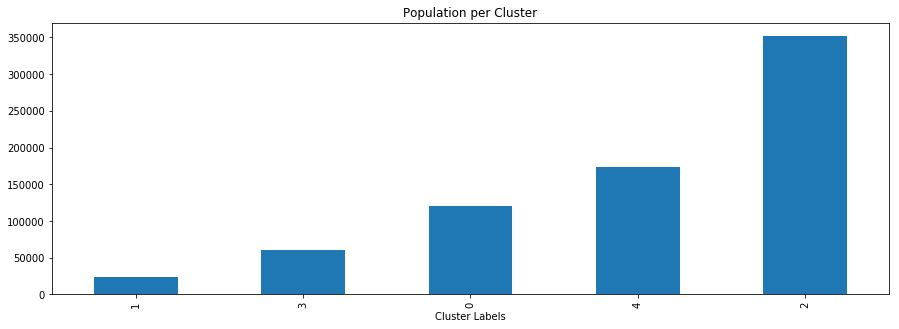

In [20]:
toronto_cluster.groupby('Cluster Labels').sum()['Population, 2016'] \
    .sort_values() \
    .plot(kind='bar', figsize=(15, 5), title= 'Population per Cluster')
plt.show()

While that is good, our ultimate test will be the amount of pharmacies per population. Once we see this, we can easily decide which cluster has the greatest potential success for a new pharmacy.

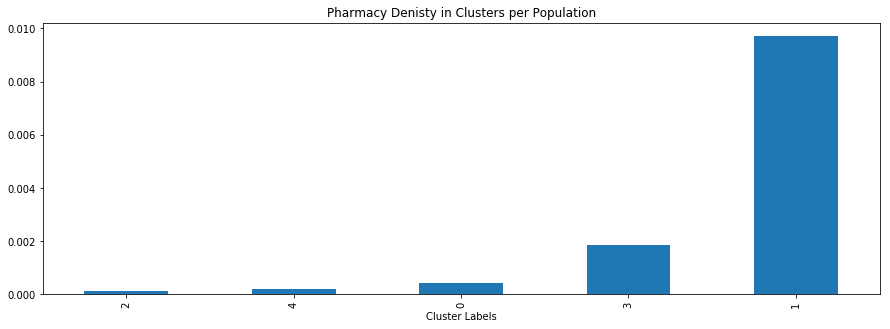

In [21]:
# Finding Pharmacy Density Per Population by dividing the number of pharmacies by population for each cluster
toronto_cluster['PharmaciesPerPop'] = toronto_cluster['PharmacyCount']/toronto_cluster['Population, 2016']
toronto_cluster = toronto_cluster.sort_values(by='PharmaciesPerPop',ascending=True)
toronto_cluster = toronto_cluster.reset_index()

# Displaying the results in a bar chart
toronto_cluster.groupby('Cluster Labels').sum()['PharmaciesPerPop'] \
    .sort_values() \
    .plot(kind='bar', figsize=(15, 5), title= 'Pharmacy Denisty in Clusters per Population')
plt.show()

# Conclusion
In this project we have identified the business problem of locating the best area for a new pharmacy in Toronto. We were able to gain the necessary data through sources online and web-scrape for what was needed. Once we had the data we prepared it for analysis and explored through Folium maps. Once this was complete we utilized machine learning through K-means clustering by grouping neighborhoods based on their similarity. Once we had done this we could finally make the suggestions to stakeholders on which cluster was most effective for the launch of a new pharmacy. Through our analysis we found that Cluster 2 proved to have the most potential for providing better access for more people in the city of Toronto.

In [22]:
# Writing our df's to CSV files.
toronto_data.to_csv('toronto_data.csv',index=False)
toronto_venues.to_csv('toronto_venues.csv',index=False)
toronto_grouped.to_csv('toronto_cluster.csv',index=False)
toronto_merged.to_csv('toronto_cluster.csv',index=False)
toronto_cluster.to_csv('toronto_cluster.csv',index=False)